In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt


from colorama import Fore, Style
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [11]:
RANDOM_STATE=42

Напишем функцию для поиска аномалий

In [12]:
def find_anomalies(data):
    anomalies_idx = []
    
    random_data_std = np.std(data)
    random_data_mean = np.mean(data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off

    
    for outlier_idx in range(len(data)):
        if data[outlier_idx] > upper_limit or data[outlier_idx] < lower_limit:
            anomalies_idx.append(outlier_idx)
    return anomalies_idx

Напишем функцию, которая будет возвращать очищенные и подготовленные данные 

In [13]:
#---------------------------------------------------------------------
#Функция для считывания данных и их обработки. 
#---------------------------------------------------------------------
def get_data():
    
    X_bp = pd.read_excel('X_bp.xlsx', index_col=0)  
    X_nup = pd.read_excel('X_nup.xlsx', index_col=0) 
    
    data = X_nup.join(X_bp, how='inner')
    numeric = data.select_dtypes([float]).columns
    
    for num in numeric:
        anomalies_idx = find_anomalies(data[num])
        data = data.drop(anomalies_idx, axis=0).reset_index(drop=True)

    feature = data.drop(columns=['Соотношение матрица-наполнитель'], axis=1)
    target = data['Соотношение матрица-наполнитель']
    
    #Convert input to numpy array
    feature = feature.to_numpy()
    target = target.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=RANDOM_STATE)
    

    #Create a scaler model that is fit on the input data.
    scaler = StandardScaler().fit(X_train)
    
    #Scale the numeric feature variables
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [14]:
#---------------------------------------------------------------------
#Функция для создания конфигурации по умолчанию для модели. 
#Это будет переопределено по мере необходимости во время экспериментов
#---------------------------------------------------------------------

def base_model_config():
    model_config = {
            "HIDDEN_NODES" : [32,64],
            "HIDDEN_ACTIVATION" : "relu",
            "OUTPUT_NODES" : 1,
            "OUTPUT_ACTIVATION" : "relu",
            "WEIGHTS_INITIALIZER" : "random_normal",
            "BIAS_INITIALIZER" : "zeros",
            "NORMALIZATION" : "none",
            "OPTIMIZER" : "rmsprop",
            "LEARNING_RATE" : 0.001,
            "REGULARIZER" : None,
            "DROPOUT_RATE" : 0.0,
            "EPOCHS" : 100,
            "BATCH_SIZE" : 32,
            "VALIDATION_SPLIT" : 0.3,
            "VERBOSE" : 0,
            "LOSS_FUNCTION" : "mse",
            "METRICS" : ["mse"]
            }
    return model_config

In [15]:
#---------------------------------------------------------------------
#Функция возвращает нужный нам optimizer
#---------------------------------------------------------------------

def get_optimizer(optimizer_name, learning_rate):
    optimizer=None
    
    if optimizer_name == 'adam' :
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
    else :
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
            
    return optimizer

In [16]:
#---------------------------------------------------------------------
#Функция создает и обучает модель на основе конфигурации, которую задал пользователь. Возвращает историю обучения
#---------------------------------------------------------------------

def create_and_run_model(model_config, model_name):
    
    X_train, X_test, y_train, y_test = get_data()
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=RANDOM_STATE)
    
    
    model=tf.keras.models.Sequential(name=model_name)
    
    for layer in range(len(model_config["HIDDEN_NODES"])):
        
        if (layer == 0):
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    input_shape=(X_train.shape[1],),
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
        else:
            
            if ( model_config["NORMALIZATION"] == "batch"):
                model.add(keras.layers.BatchNormalization())
                
            if ( model_config["DROPOUT_RATE"] > 0.0 ):
                model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))
                
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"])) 
            

            
    model.add(keras.layers.Dense(model_config["OUTPUT_NODES"],
                    name="Output-Layer",
                    activation=model_config["OUTPUT_ACTIVATION"]))
    
    optimizer = get_optimizer( model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])
    
    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                   metrics=model_config["METRICS"])
    
    print("\n******************************************************")
    model.summary()
    
    early_stopping = EarlyStopping(
    min_delta = 0.0005, 
    patience  = 15,     
    restore_best_weights=True,)
    
    
    history=model.fit(X_train,
                      y_train,
                      batch_size=model_config["BATCH_SIZE"],
                      epochs=model_config["EPOCHS"],
                      callbacks=[early_stopping],
                      verbose=model_config["VERBOSE"],
                      validation_data=(X_valid, y_valid))
    
    return history

In [17]:
#---------------------------------------------------------------------
#Функция для построения графика на основе полученных результатов
#---------------------------------------------------------------------

def plot_graph(mse_measures, title):
    
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, len(mse_measures))]
    
    plt.figure(figsize=(15, 8))
    for i, experiment in enumerate(mse_measures.keys()):
        plt.plot(mse_measures[experiment], 
                 label=experiment, color=colors[i],
                    linewidth=3)
    plt.ylim([0.5, 1.4])    
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

Подберем необходимые:

+ Кол-во слоев и кол-во нейронов
+ Функции активации
+ Batch Normalization
+ Метод оптимизации
+ Темп обучения (learning rate)
+ Dropout


In [18]:
mse_layer_neuron = {}

for neuron in range(5, 30, 5):
    layer_list = []
    for layer_count in range(3,5):
    
        layer_list.append(neuron)
        model_config = base_model_config()

        model_config["HIDDEN_NODES"] = layer_list
        model_name = f"Layers-{layer_count}-neurons-{neuron}"
        history = create_and_run_model(model_config ,model_name)

        mse_layer_neuron[model_name] = history.history["val_mse"]


******************************************************
Model: "Layers-3-neurons-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 Output-Layer (Dense)        (None, 1)                 6         
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Layers-4-neurons-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 Dense-Layer-1 (Dense)       (None, 5)      

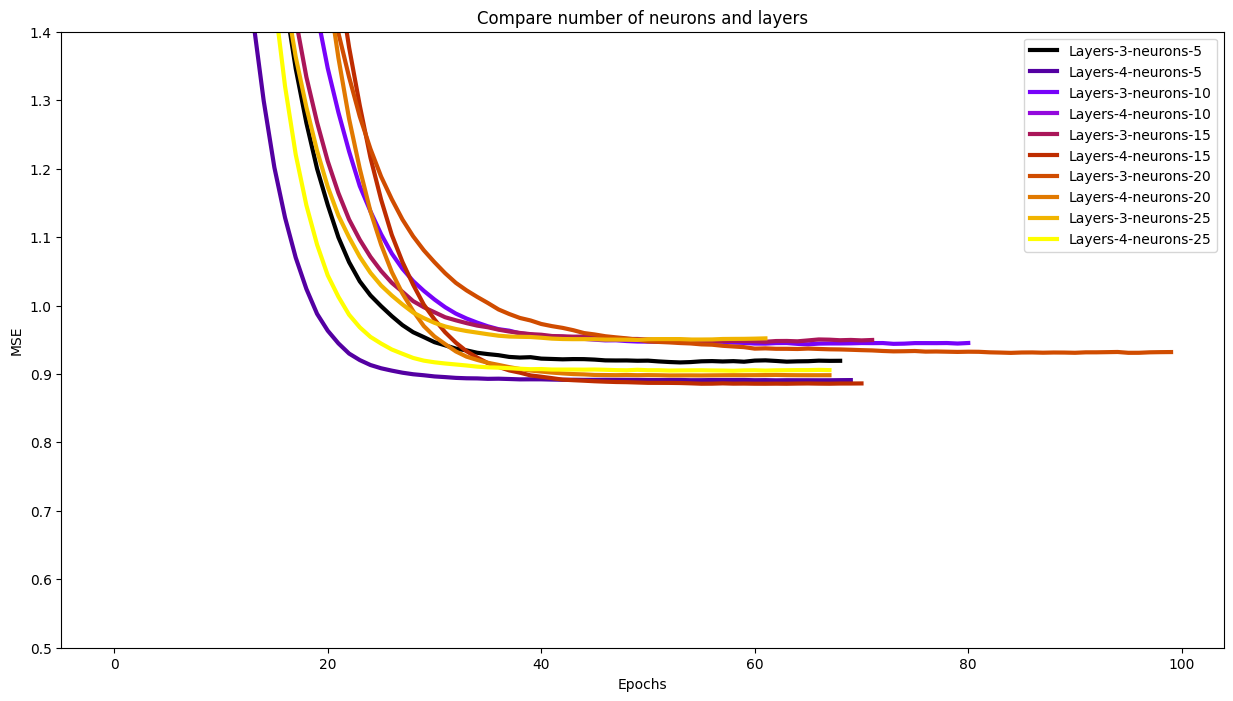

In [19]:
plot_graph(mse_layer_neuron, "Compare number of neurons and layers")

Самая лучшая модель оказалась при архитектуре, когда у нас 5 нейронов и 4 слоя

Теперь подберем функцию активации

In [20]:
mse_activation = {}
activation_list = ['relu','LeakyReLU', 'ELU']

layer_list = []
for layer_count in range(4):
    layer_list.append(5)
        
for activation in activation_list:
    
    model_config = base_model_config()
    
    
    model_config["HIDDEN_NODES"] = layer_list
    model_config["HIDDEN_ACTIVATION"] = activation
    model_name = "Model-" + activation
    history=create_and_run_model(model_config ,model_name)
    
    mse_activation["Model-" + activation] = history.history["val_mse"]



******************************************************
Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 Dense-Layer-1 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-2 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-3 (Dense)       (None, 5)                 30        
                                                                 
 Output-Layer (Dense)        (None, 1)                 6         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________

*

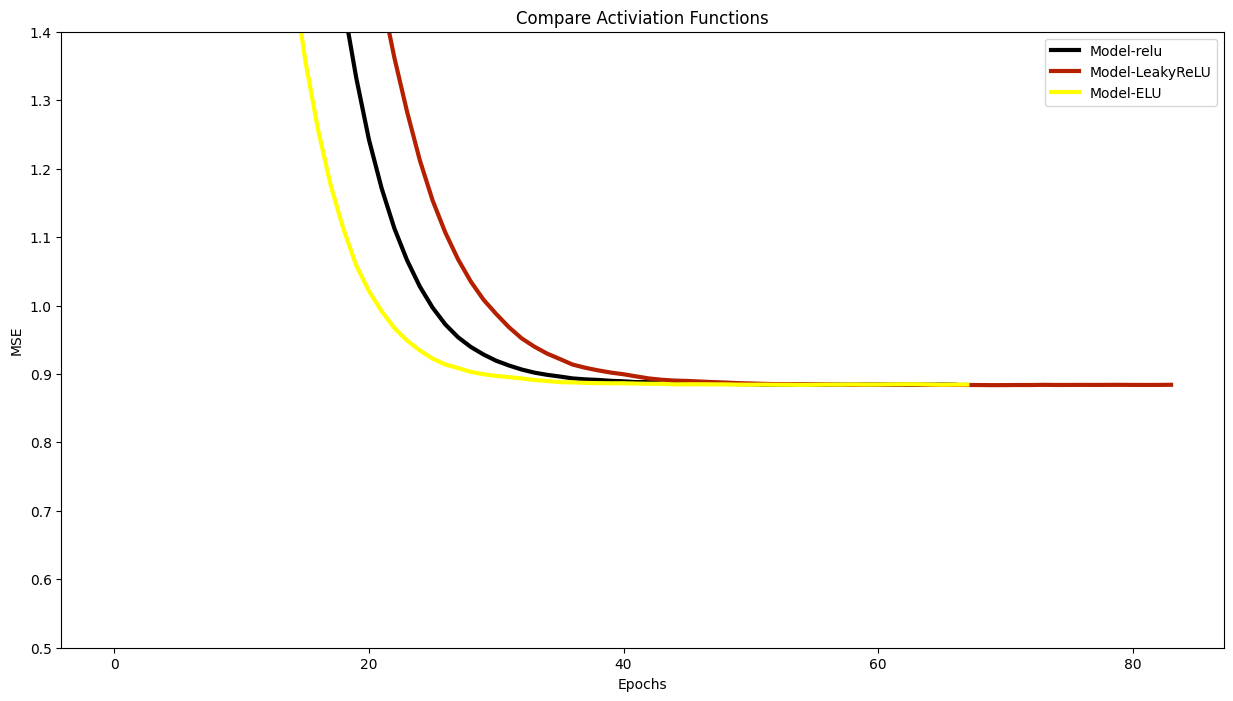

In [21]:
plot_graph(mse_activation, "Compare Activiation Functions")

Самой лучшей функцией активации оказалась ELU

Теперь посмотрим, с нужна ли нам Batch Normalization

In [22]:
mse_normalization = {}

normalization_list = ['none','batch']
for normalization in normalization_list:
    
    model_config = base_model_config()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_config["HIDDEN_ACTIVATION"] = 'ELU'
    
    model_config["NORMALIZATION"] = normalization
    model_name="Normalization-" + normalization
    history = create_and_run_model(model_config, model_name)
    
    mse_normalization[model_name] = history.history["val_mse"]



******************************************************
Model: "Normalization-none"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 Dense-Layer-1 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-2 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-3 (Dense)       (None, 5)                 30        
                                                                 
 Output-Layer (Dense)        (None, 1)                 6         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
____________________________________________________________

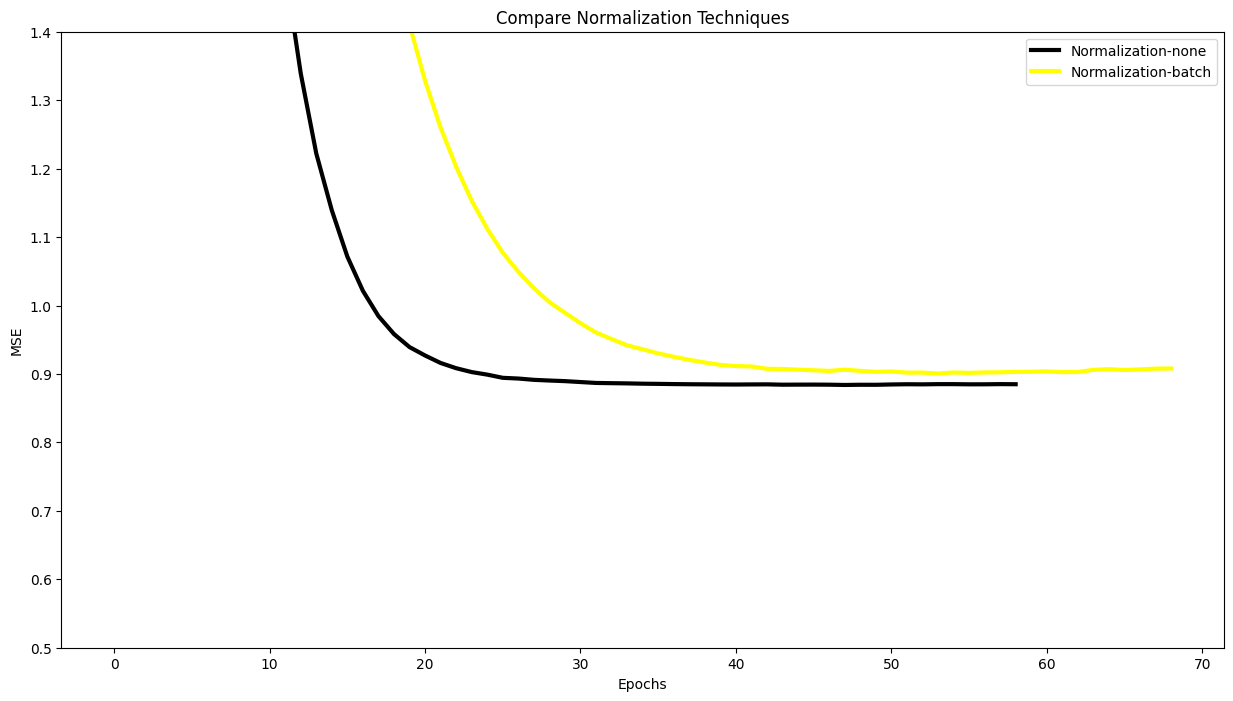

In [23]:
plot_graph(mse_normalization, "Compare Normalization Techniques")

Видим, что при Batch Normalization = None модель себя показывает лучше

Следующим шагом подберем оптимизатор

In [24]:
mse_optimizer = {}

optimizer_list = ['sgd','adam']
for optimizer in optimizer_list:
    
    model_config = base_model_config()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_config["HIDDEN_ACTIVATION"] = 'ELU'
    model_config["NORMALIZATION"] = 'none'
    
    model_config["OPTIMIZER"] = optimizer
    model_name = "Optimizer-" + optimizer
    history = create_and_run_model(model_config, model_name)
    
    mse_optimizer[model_name] = history.history["val_mse"]


******************************************************
Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 Dense-Layer-1 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-2 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-3 (Dense)       (None, 5)                 30        
                                                                 
 Output-Layer (Dense)        (None, 1)                 6         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________

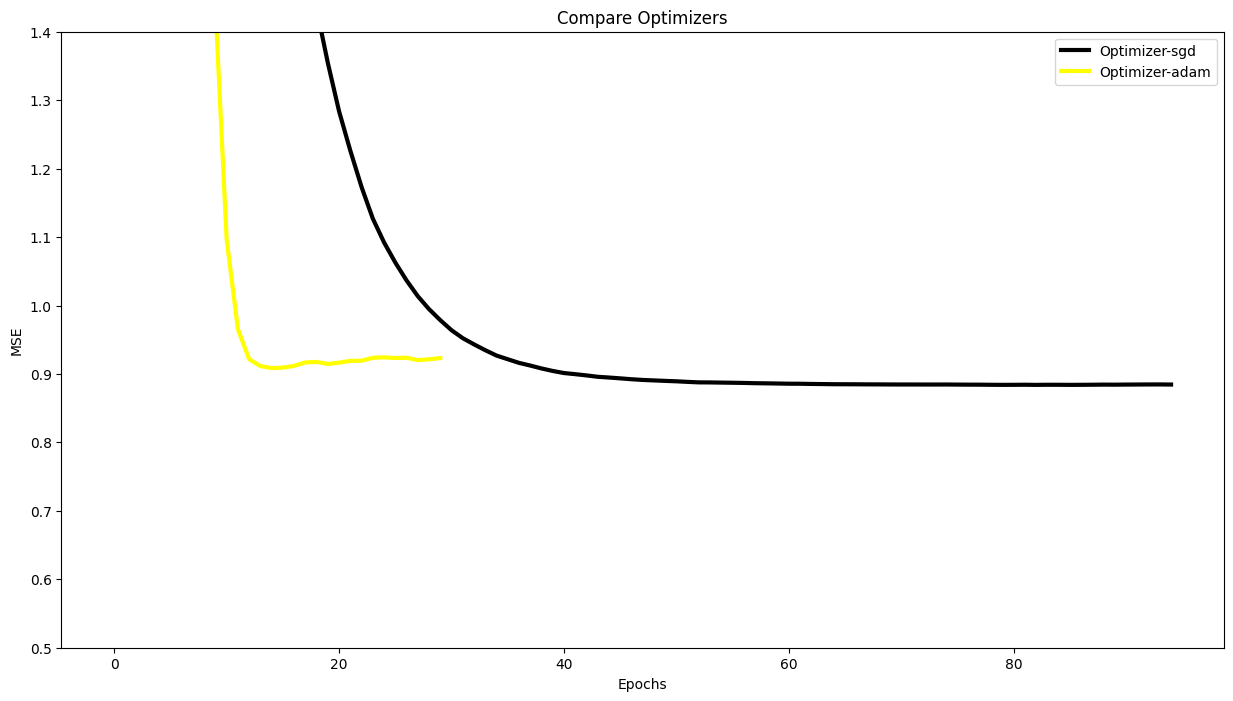

In [25]:
plot_graph(mse_optimizer, "Compare Optimizers")

SGD показал более стабильный результат


Теперь подберем шаг для оптимизатора

In [26]:
mse_learning_rate = {}

learning_rate_list = [0.001, 0.005 ,0.015 ,0.1 ,0.5]
for learning_rate in learning_rate_list:
    
    model_config = base_model_config()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_config["HIDDEN_ACTIVATION"] = 'ELU'
    model_config["NORMALIZATION"] = 'none'
    model_config["OPTIMIZER"] = 'sgd'
    
    model_config["LEARNING_RATE"] = learning_rate
    model_name="Learning-Rate-" + str(learning_rate)
    history = create_and_run_model(model_config, model_name)
    
    mse_learning_rate[model_name] = history.history["val_mse"]


******************************************************
Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 Dense-Layer-1 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-2 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-3 (Dense)       (None, 5)                 30        
                                                                 
 Output-Layer (Dense)        (None, 1)                 6         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
___________________________________________________________

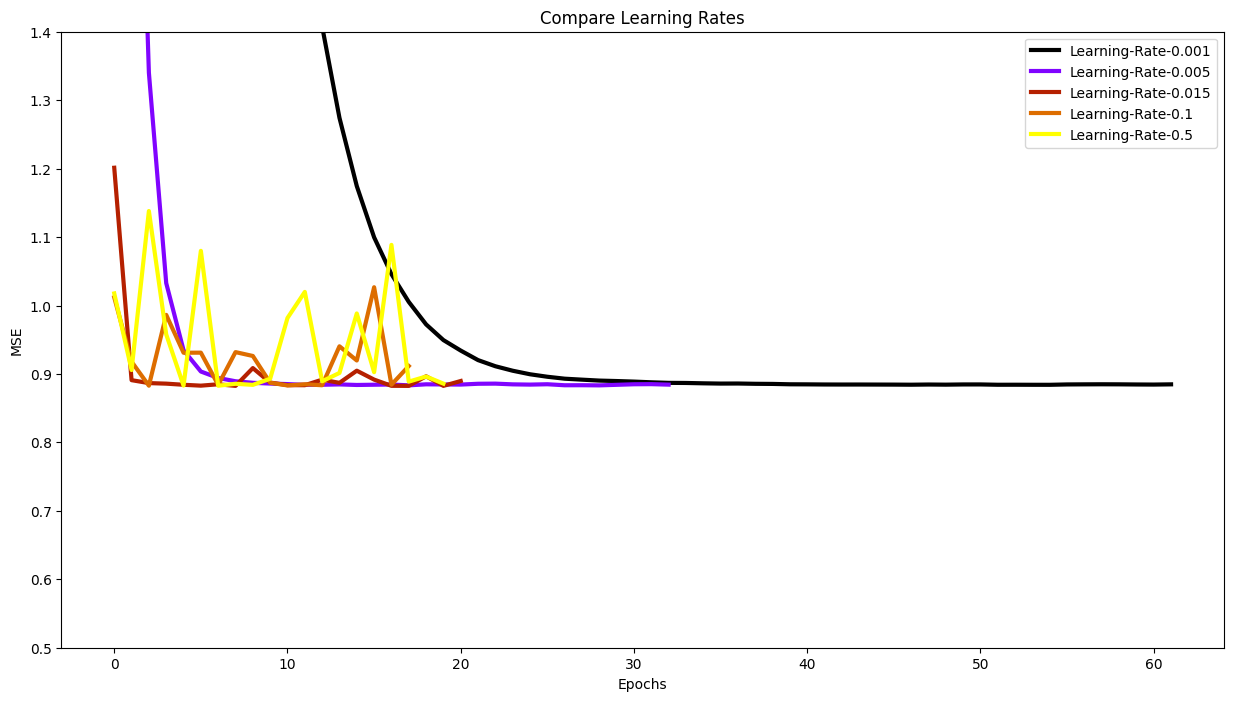

In [27]:
plot_graph(mse_learning_rate, "Compare Learning Rates")

При 0.015 модель лучше всего сходится

Подберем вероятность отключения нейронов (Dropout)

In [28]:
mse_dropout = {}

dropout_list = [0.0, 0.1, 0.2, 0.25, 0.3, 0.35]
for dropout in dropout_list:
    
    model_config = base_model_config()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_config["HIDDEN_ACTIVATION"] = 'ELU'
    model_config["NORMALIZATION"] = 'none'
    model_config["OPTIMIZER"] = 'sgd'
    model_config["LEARNING_RATE"] = 0.015
    
    model_config["DROPOUT_RATE"] = dropout
    model_name="Dropout-" + str(dropout)
    history = create_and_run_model(model_config, model_name)
    
    mse_dropout[model_name] = history.history["val_mse"]


******************************************************
Model: "Dropout-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 Dense-Layer-1 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-2 (Dense)       (None, 5)                 30        
                                                                 
 Dense-Layer-3 (Dense)       (None, 5)                 30        
                                                                 
 Output-Layer (Dense)        (None, 1)                 6         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________



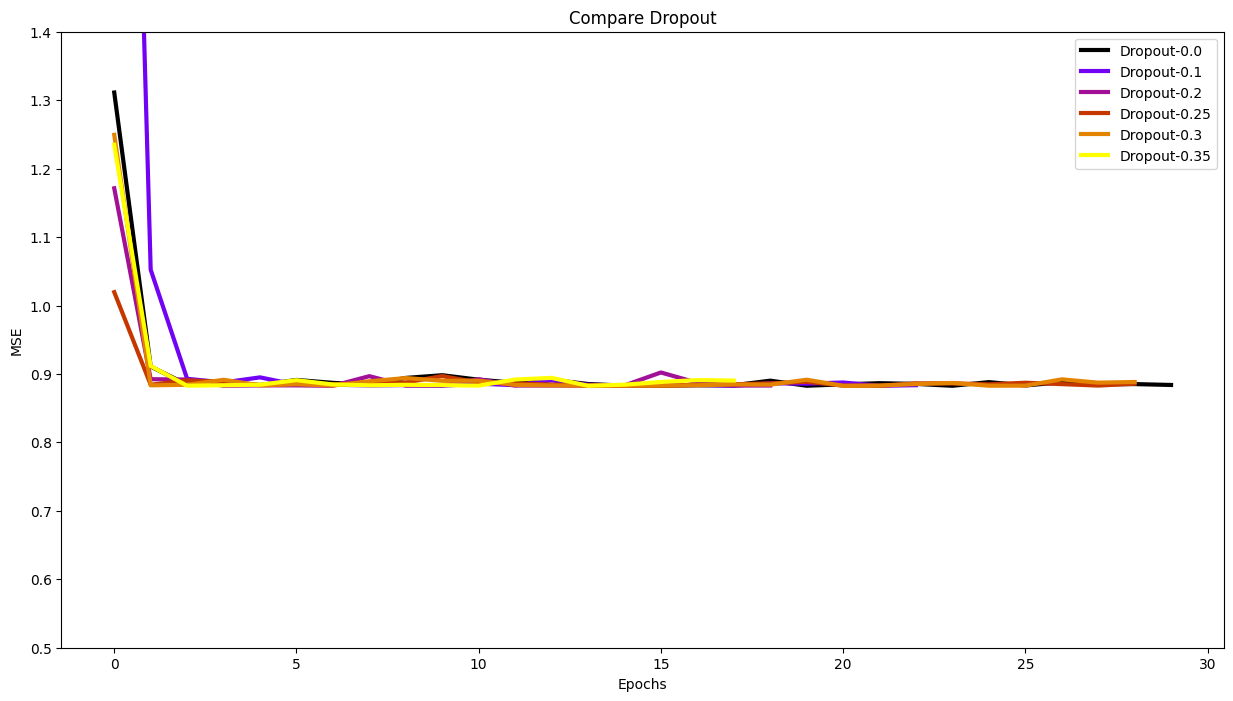

In [29]:
plot_graph(mse_dropout, "Compare Dropout")

Для нашей задачи хорошо подходит 0.25 для Dropout

In [30]:
mse_final = {}

#Base model
model_config = base_model_config()                       #
model_config["HIDDEN_NODES"] = [16]                      #
model_config["NORMALIZATION"] = None                     #
model_config["OPTIMIZER"] = "adam"                       #
model_config["LEARNING_RATE"] = 0.1                      #
model_config["REGULARIZER"] = None                       #
model_config["DROPOUT_RATE"] = 0.0                       #



model_name = "Base-Model-" + str(layer_count)

history = create_and_run_model(model_config, model_name)
    
mse_final[model_name] = history.history["val_mse"]

#Optimization model
model_config = base_model_config()
model_config["HIDDEN_ACTIVATION"] = 'ELU'
model_config["HIDDEN_NODES"] = layer_list
model_config["NORMALIZATION"] = "none"
model_config["OPTIMIZER"] = "sgd"
model_config["LEARNING_RATE"] = 0.015
model_config["DROPOUT_RATE"] = 0.25


model_name = "Optimized-Model-" + str(layer_count)

history = create_and_run_model(model_config, model_name)
    
mse_final[model_name] = history.history["val_mse"]


******************************************************
Model: "Base-Model-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 16)                208       
                                                                 
 Output-Layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Optimized-Model-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 dropout_15 (Dropout)        (None, 5)           

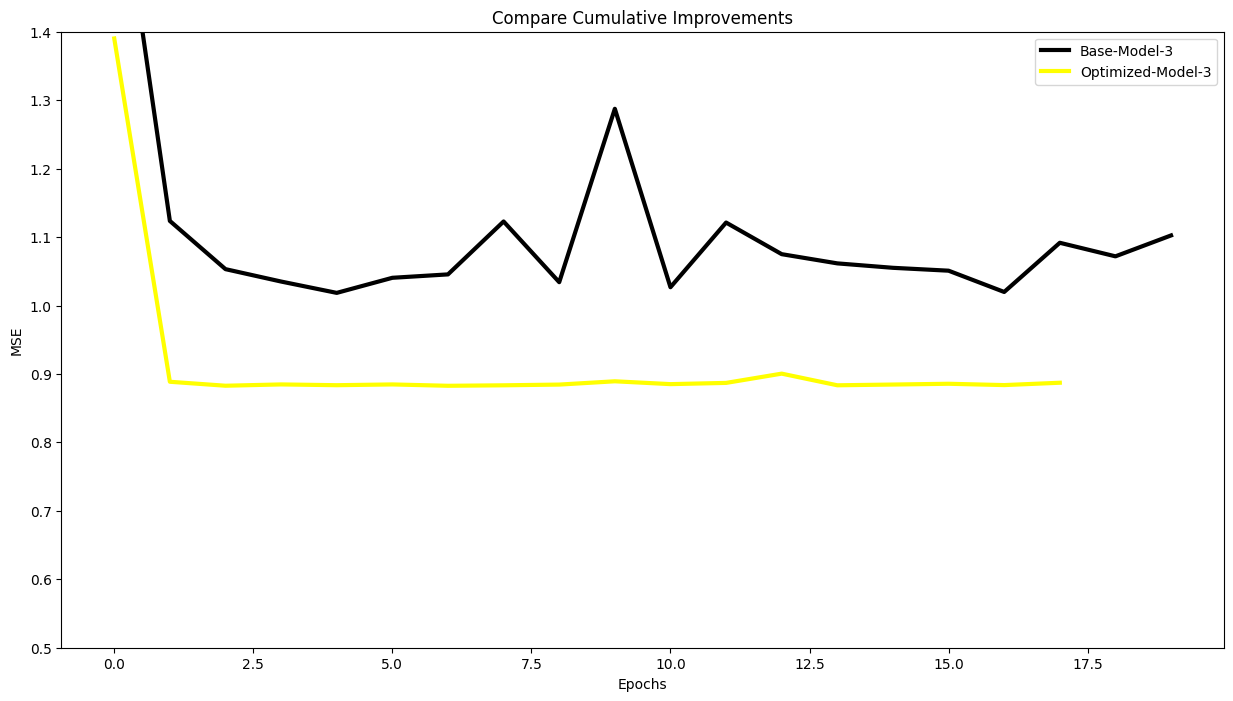

In [31]:
plot_graph(mse_final, "Compare Cumulative Improvements")

Довольно сильно получилось улучшить качество модели

Теперь протестируем ее

In [32]:
X_train, X_test, y_train, y_test = get_data()

#Optimization model
model_config = base_model_config()
model_config["HIDDEN_ACTIVATION"] = 'ELU'
model_config["HIDDEN_NODES"] = layer_list
model_config["NORMALIZATION"] = "none"
model_config["OPTIMIZER"] = "sgd"
model_config["LEARNING_RATE"] = 0.015
model_config["DROPOUT_RATE"] = 0.25

model=tf.keras.models.Sequential(name='final_model')

for layer in range(len(model_config["HIDDEN_NODES"])):

    if (layer == 0):
        model.add(
                keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                input_shape=(X_train.shape[1],),
                name="Dense-Layer-" + str(layer),
                kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                bias_initializer = model_config["BIAS_INITIALIZER"],
                kernel_regularizer=model_config["REGULARIZER"],
                activation=model_config["HIDDEN_ACTIVATION"]))
    else:

        if ( model_config["NORMALIZATION"] == "batch"):
            model.add(keras.layers.BatchNormalization())

        if ( model_config["DROPOUT_RATE"] > 0.0 ):
            model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))

        model.add(
                keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                name="Dense-Layer-" + str(layer),
                kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                bias_initializer = model_config["BIAS_INITIALIZER"],
                kernel_regularizer=model_config["REGULARIZER"],
                activation=model_config["HIDDEN_ACTIVATION"])) 



model.add(keras.layers.Dense(model_config["OUTPUT_NODES"],
                name="Output-Layer",
                activation=model_config["OUTPUT_ACTIVATION"]))

optimizer = get_optimizer( model_config["OPTIMIZER"],
                          model_config["LEARNING_RATE"])

model.compile(loss=model_config["LOSS_FUNCTION"],
              optimizer=optimizer,
               metrics=model_config["METRICS"])

print("\n******************************************************")
model.summary()

early_stopping = EarlyStopping(
min_delta = 0.0005, 
patience  = 15,     
restore_best_weights=True,)


model.fit(X_train,
          y_train,
          batch_size=model_config["BATCH_SIZE"],
          epochs=model_config["EPOCHS"],
          callbacks=[early_stopping],
          verbose=model_config["VERBOSE"],
          validation_data=(X_test, y_test))


******************************************************
Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 5)                 65        
                                                                 
 dropout_18 (Dropout)        (None, 5)                 0         
                                                                 
 Dense-Layer-1 (Dense)       (None, 5)                 30        
                                                                 
 dropout_19 (Dropout)        (None, 5)                 0         
                                                                 
 Dense-Layer-2 (Dense)       (None, 5)                 30        
                                                                 
 dropout_20 (Dropout)        (None, 5)                 0         
                                                                 

In [34]:
rmse_test = mean_squared_error(model.predict(X_test), y_test, squared=False)
print(f"RMSE on test: {rmse_test:.3f}")

10/10 [==============================] - 0s 556us/step
RMSE on test: 0.904


In [25]:
model.save('best_keras_model')

INFO:tensorflow:Assets written to: best_keras_model\assets


INFO:tensorflow:Assets written to: best_keras_model\assets


In [27]:
model.save('D:\keras_project\model')

INFO:tensorflow:Assets written to: D:\keras_project\model\assets


INFO:tensorflow:Assets written to: D:\keras_project\model\assets
